In [1]:
# pip installs

!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q --upgrade requests==2.32.3 bitsandbytes==0.46.0 transformers==4.48.3 accelerate==1.3.0 datasets==3.2.0 peft==0.14.0 trl==0.14.0 matplotlib wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 113.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 40.2 MB/s eta 0:00:00
  Attempting uninstall: bitsandbytes
    Found existing installation: bitsandbytes 0.46.0
    Uninstalling bitsandbytes-0.46.0:
      Successfully uninstalled bitsandbytes-0.46.0


In [54]:
import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, set_seed, BitsAndBytesConfig
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
from peft import LoraConfig, PeftModel
from trl import SFTTrainer, SFTConfig, DataCollatorForCompletionOnlyLM
import matplotlib.pyplot as plt
import wandb
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig
from datetime import datetime
import matplotlib.pyplot as plt

In [41]:
# Constants

BASE_MODEL = "meta-llama/Llama-3.2-1B"
PROJECT_NAME = "pricer-2025"
HF_USER = "javedumar507" # your HF name here!

# Data

# DATASET_NAME = f"{HF_USER}/pricer-data"
# Or just use the one I've uploaded
DATASET_NAME = "ed-donner/pricer-data"
MAX_SEQUENCE_LENGTH = 182

# Run name for saving the model in the hub

RUN_NAME =  "pricer-2025"
PROJECT_RUN_NAME = "pricer-2025"
HUB_MODEL_NAME = f"{HF_USER}/{PROJECT_RUN_NAME}"

# Hyperparameters for QLoRA

LORA_R = 16
LORA_ALPHA = 32
TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj", "up_proj", "down_proj"]
LORA_DROPOUT = 0.1
QUANT_4_BIT = True

# Hyperparameters for Training

EPOCHS = 1 # you can do more epochs if you wish, but only 1 is needed - more is probably overkill
BATCH_SIZE = 4 # on an A100 box this can go up to 16
GRADIENT_ACCUMULATION_STEPS = 1
LEARNING_RATE = 5e-5
LR_SCHEDULER_TYPE = 'cosine'
WARMUP_RATIO = 0.01
OPTIMIZER = "paged_adamw_32bit"

# Admin config - note that SAVE_STEPS is how often it will upload to the hub
# I've changed this from 5000 to 2000 so that you get more frequent saves

STEPS = 50
SAVE_STEPS = 2000
LOG_TO_WANDB = True

%matplotlib inline

In [42]:
HUB_MODEL_NAME

'javedumar507/pricer-2025'

### Log in to HuggingFace and Weights & Biases

If you don't already have a HuggingFace account, visit https://huggingface.co to sign up and create a token.

Then select the Secrets for this Notebook by clicking on the key icon in the left, and add a new secret called `HF_TOKEN` with the value as your token.

Repeat this for weightsandbiases at https://wandb.ai and add a secret called `WANDB_API_KEY`

In [43]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [44]:
# Log in to Weights & Biases
wandb_api_key = userdata.get('WANDB_API_KEY')
os.environ["WANDB_API_KEY"] = wandb_api_key
wandb.login()

# Configure Weights & Biases to record against our project
os.environ["WANDB_PROJECT"] = PROJECT_NAME
os.environ["WANDB_LOG_MODEL"] = "checkpoint" if LOG_TO_WANDB else "end"
os.environ["WANDB_WATCH"] = "gradients"

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [14]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test'].select(range(1000)) if dataset['test'] > 1000 else dataset['test']

README.md:   0%|          | 0.00/416 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/914k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [37]:
# if you wish to reduce the training dataset to 20,000 points instead, then uncomment this line:
train = train.select(range(20000))

In [32]:
if LOG_TO_WANDB:
  wandb.init(project=PROJECT_NAME, name=RUN_NAME)

## Now load the Tokenizer and Model

The model is "quantized" - we are reducing the precision to 4 bits.

In [47]:
# pick the right quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [48]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e6:.1f} MB")

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Memory footprint: 1012.0 MB


In [49]:
from trl import DataCollatorForCompletionOnlyLM
response_template = "Price is $"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

# AND NOW

## We set up the configuration for Training

We need to create 2 objects:

A LoraConfig object with our hyperparameters for LoRA

An SFTConfig with our overall Training parameters

In [50]:
# First, specify the configuration parameters for LoRA

lora_parameters = LoraConfig(
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    r=LORA_R,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=TARGET_MODULES,
)

# Next, specify the general configuration parameters for training

train_parameters = SFTConfig(
    output_dir=PROJECT_RUN_NAME,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=1,
    eval_strategy="no",
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIMIZER,
    save_steps=SAVE_STEPS,
    save_total_limit=10,
    logging_steps=STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=WARMUP_RATIO,
    group_by_length=True,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    report_to="wandb" if LOG_TO_WANDB else None,
    run_name=RUN_NAME,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dataset_text_field="text",
    save_strategy="steps",
    hub_model_id=HUB_MODEL_NAME,
    hub_private_repo=False
)

# And now, the Supervised Fine Tuning Trainer will carry out the fine-tuning
# Given these 2 sets of configuration parameters
# The latest version of trl is showing a warning about labels - please ignore this warning
# But let me know if you don't see good training results (loss coming down).

fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=train,
    peft_config=lora_parameters,
    args=train_parameters,
    data_collator=collator
  )

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [51]:
fine_tuning.train()

fine_tuning.model.push_to_hub(HUB_MODEL_NAME, token=hf_token)
tokenizer.push_to_hub(HUB_MODEL_NAME, token=hf_token)
print(f"Saved to the hub: {HUB_MODEL_NAME}")
# uploading to Hugging face have some issues will resolve later.

Step,Training Loss
50,2.178300
100,1.968800
150,2.047600
200,2.016900
250,2.057700
300,1.997300
350,2.010400
400,2.005600
450,1.994000
500,1.961400


wandb: Adding directory to artifact (pricer-2025/checkpoint-2000)... Done. 0.7s
wandb: Adding directory to artifact (pricer-2025/checkpoint-4000)... Done. 0.8s
wandb: Adding directory to artifact (pricer-2025/checkpoint-5000)... Done. 0.8s


HfHubHTTPError: (Request ID: Root=1-69007ed5-0756ad9c3deaf03e6d554d62;4d057838-b46f-4dde-8057-1fa4277d44ab)

403 Forbidden: You don't have the rights to create a model under the namespace "javedumar507".
Cannot access content at: https://huggingface.co/api/repos/create.
Make sure your token has the correct permissions.

In [52]:
if LOG_TO_WANDB:
  wandb.finish()

train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
train/global_step,▁▁▁▂▃▃▄▄▄▄▅▅▅▅▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
train/grad_norm,▄▄▃▂▅▂▂▂▁▂▂▂▂▁▂█▂▂▃▂▂▁▂▁▂▁▂▂▂▁▂▁▁▃▁▂▁▄▂▂
train/learning_rate,▁▃▃▅▆████████████████▇▇▇▇▆▆▆▆▅▃▂▂▂▂▁▁▁▁▁
train/loss,█▂▂▂▁▂▂▂▂▂▂▂▁▂▂▁▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
total_flos,2.149777988542464e+16
train/epoch,1
train/global_step,5000
train/grad_norm,4.05501
train/learning_rate,0
train/loss,1.8538


In [57]:
# Load from LOCAL checkpoint
LOCAL_CHECKPOINT = "pricer-2025/checkpoint-5000"

fine_tuned_model = PeftModel.from_pretrained(base_model, LOCAL_CHECKPOINT)
print(f"Fine-tuned model loaded from local checkpoint. Memory: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")


Fine-tuned model loaded from local checkpoint. Memory: 1150.6 MB


In [58]:
def extract_price(s):
    if "Price is $" in s:
        contents = s.split("Price is $")[1]
        contents = contents.replace(',','')
        match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
        return float(match.group()) if match else 0
    return 0


In [59]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = fine_tuned_model.generate(inputs, attention_mask=attention_mask, max_new_tokens=3, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)


In [63]:
top_K = 3

def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)
    prices, weights = [], []
    for i in range(top_K):
        predicted_token = tokenizer.decode(top_token_id[0][i])
        probability = top_prob[0][i]
        try:
            result = float(predicted_token)
        except ValueError as e:
            result = 0.0
        if result > 0:
            prices.append(result)
            weights.append(probability)
    if not prices:
        return 0.0
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()

fine_tuned_model = fine_tuned_model.float()

In [64]:
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()


1: Guess: $276.51 Truth: $374.41 Error: $97.90 SLE: 0.09 Item: OEM AC Compressor w/...
2: Guess: $152.92 Truth: $225.11 Error: $72.19 SLE: 0.15 Item: Motorcraft YB3125 Fa...
3: Guess: $53.93 Truth: $61.68 Error: $7.75 SLE: 0.02 Item: Dorman Front Washer ...
4: Guess: $347.58 Truth: $599.99 Error: $252.41 SLE: 0.30 Item: HP Premium HD Plus T...
5: Guess: $35.72 Truth: $16.99 Error: $18.73 SLE: 0.51 Item: Super Switch Pickup ...
6: Guess: $8.02 Truth: $31.99 Error: $23.97 SLE: 1.68 Item: Horror Bookmarks, Re...
7: Guess: $117.70 Truth: $101.79 Error: $15.91 SLE: 0.02 Item: SK6241 - Stinger 4 G...
8: Guess: $311.53 Truth: $289.00 Error: $22.53 SLE: 0.01 Item: Godox ML60Bi LED Lig...
9: Guess: $429.95 Truth: $635.86 Error: $205.91 SLE: 0.15 Item: Randall G3 Plus Comb...
10: Guess: $70.19 Truth: $65.99 Error: $4.20 SLE: 0.00 Item: HOLDWILL 6 Pack LED ...
11: Guess: $350.94 Truth: $254.21 Error: $96.73 SLE: 0.10 Item: Viking Horns 3 Gallo...
12: Guess: $182.63 Truth: $412.99 Error: $230.36 S

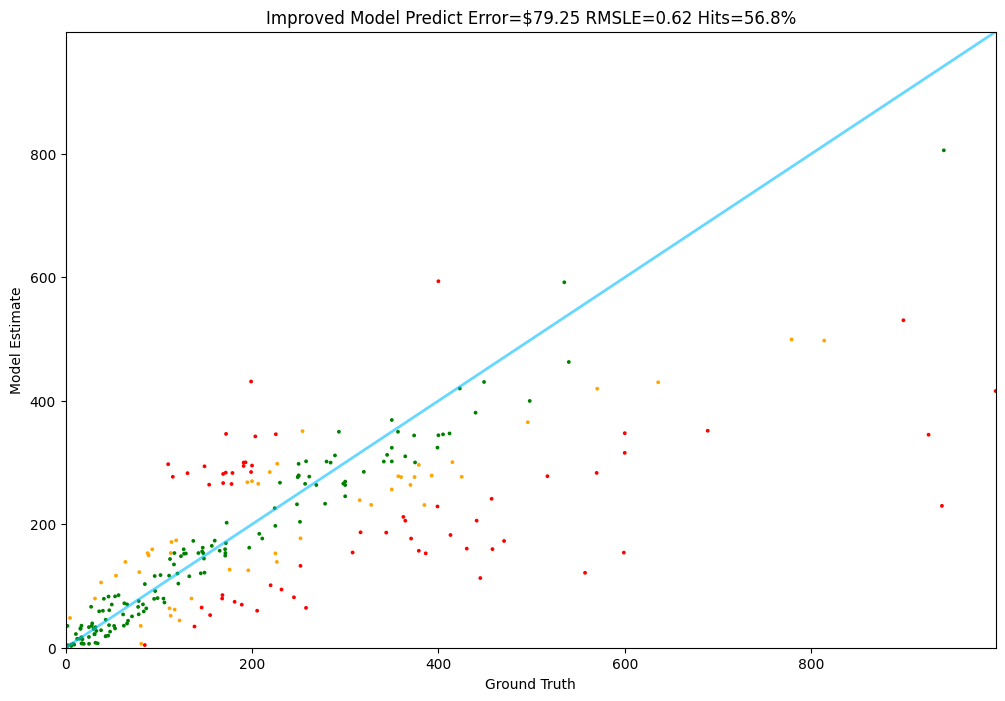

In [65]:
Tester.test(improved_model_predict, test)
